<a href="https://colab.research.google.com/github/alizul01/2141720088-PCVK-2023/blob/main/10_Thresholding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Library

In [1]:
!pip install pytesseract
!sudo apt-get install tesseract-ocr-ind

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-ind tesseract-ocr-osd
0 upgraded, 4 newly installed, 0 to remove and 19 not upgraded.
Need to get 5,353 kB of archives.
After this operation, 16.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-ind all 1:4.00~git30-7274cfa-1.1 [537 kB]
Fetched 5,353 kB in 1s (5,467 kB/s)
debconf: unable to ini

In [14]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pytesseract
from google.colab.patches import cv2_imshow
from skimage.morphology import skeletonize, thin
from skimage.util import invert
from sklearn.cluster import KMeans

## Method

In [57]:
def load_image(file_path):
    img = cv2.imread(file_path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def compare_images(original, processed, title_before='Original', title_after='Processed', cmap=None):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap=cmap)
    plt.title(title_before)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(processed, cmap=cmap)
    plt.title(title_after)
    plt.axis('off')

    plt.show()

def _compute_otsu_criteria(im, th):
    thresholded_im = np.zeros(im.shape)
    thresholded_im[im >= th] = 1

    nb_pixels = im.size
    nb_pixels1 = np.count_nonzero(thresholded_im)
    weight1 = nb_pixels1 / nb_pixels
    weight0 = 1 - weight1

    if weight1 == 0 or weight0 == 0:
        return np.inf

    val_pixels1 = im[thresholded_im == 1]
    val_pixels0 = im[thresholded_im == 0]

    var1 = np.var(val_pixels1) if len(val_pixels1) > 0 else 0
    var0 = np.var(val_pixels0) if len(val_pixels0) > 0 else 0

    return weight0 * var0 + weight1 * var1

def otsuThresholding(img: np.ndarray) -> np.ndarray:
    threshold_range = range(np.max(img)+1)
    criterias = np.array([_compute_otsu_criteria(img, th) for th in threshold_range])

    best_threshold = threshold_range[np.argmin(criterias)]

    binary = img
    binary[binary > best_threshold] = 255
    binary[binary <= best_threshold] = 0

    return binary

def preprocessing(img, typeby):
    """
    Perform preprocessing steps on an image.

    Args:
        img (numpy array): An image to be preprocessed.
        typeby (str): The type of preprocessing to be applied.

    Returns:
        numpy array: The preprocessed image.
    """
    preprocessed_img = img

    if typeby == 'grayscale':
        preprocessed_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    elif typeby == 'binary':
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, preprocessed_img = cv2.threshold(gray_img, 127, 255, cv2.THRESH_BINARY)
    elif typeby == 'blur':
        preprocessed_img = cv2.GaussianBlur(img, (5, 5), 0)

    return preprocessed_img

def segment_image(img, n_clusters):
    """
    Segment an image using K-Means algorithm.

    Args:
        img (numpy array): An image to be segmented.
        n_clusters (int): The number of clusters to be used.

    Returns:
        numpy array: The segmented image.
    """
    img_reshaped = img.reshape(-1, 3)

    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(img_reshaped)

    labels = kmeans.labels_

    labels_reshaped = labels.reshape(img.shape[0], img.shape[1])

    return labels_reshaped

def compare_images(original, processed, title_before='Original', title_after='Processed', cmap=None):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap=cmap)
    plt.title(title_before)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(processed, cmap=cmap)
    plt.title(title_after)
    plt.axis('off')

    plt.show()

def otsu(gray):
    pixel_number = gray.shape[0] * gray.shape[1]
    mean_weigth = 1.0/pixel_number
    his, bins = np.histogram(gray, np.array(range(0, 256)))
    final_thresh = -1
    final_value = -1
    for t in bins[1:-1]: # This goes from 1 to 254 uint8 range (Pretty sure wont be those values)
        Wb = np.sum(his[:t]) * mean_weigth
        Wf = np.sum(his[t:]) * mean_weigth

        mub = np.mean(his[:t])
        muf = np.mean(his[t:])

        value = Wb * Wf * (mub - muf) ** 2

        print("Wb", Wb, "Wf", Wf)
        print("t", t, "value", value)

        if value > final_value:
            final_thresh = t
            final_value = value
    final_img = gray.copy()
    print(final_thresh)
    final_img[gray > final_thresh] = 255
    final_img[gray < final_thresh] = 0
    return final_img

## Thresholding Global

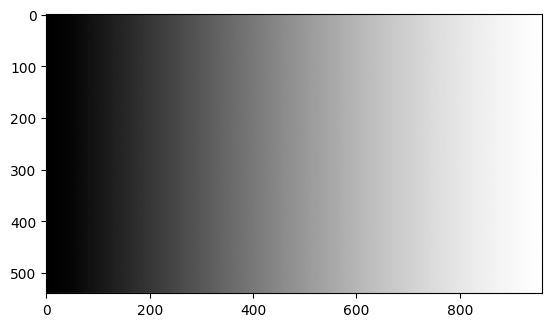

In [5]:
img = load_image('gradient.jpg')
plt.imshow(img)

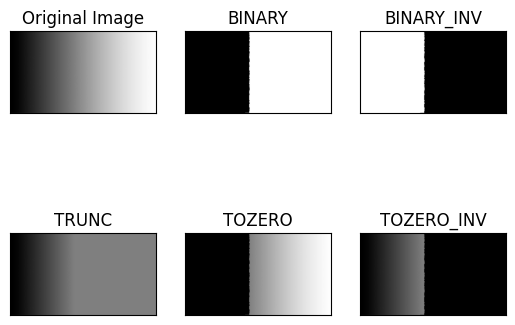

In [6]:
thresh = 127
ret, thresh_1 = cv2.threshold(img, thresh, 255, cv2.THRESH_BINARY)
ret, thresh_2 = cv2.threshold(img, thresh, 255, cv2.THRESH_BINARY_INV)
ret, thresh_3 = cv2.threshold(img, thresh, 255, cv2.THRESH_TRUNC)
ret, thresh_4 = cv2.threshold(img, thresh, 255, cv2.THRESH_TOZERO)
ret, thresh_5 = cv2.threshold(img, thresh, 255, cv2.THRESH_TOZERO_INV)

titles = ['Original Image','BINARY','BINARY_INV','TRUNC', 'TOZERO', 'TOZERO_INV']
images = [img, thresh_1, thresh_2, thresh_3, thresh_4, thresh_5]

for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i], 'gray')
    plt.title(titles[i])
    plt.xticks([]), plt.yticks([])

plt.show()

## Otsu Thresholding

### No Library

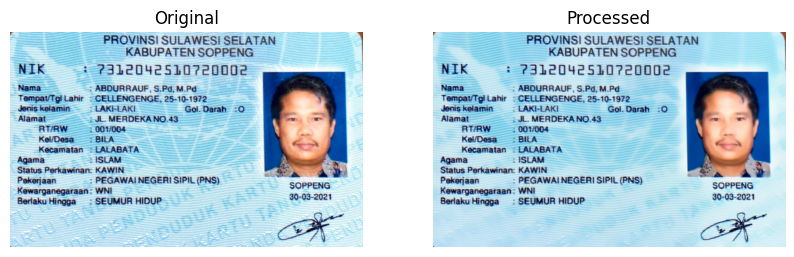

In [7]:
ktp_image = load_image('ktp.jpeg')
ktp_denoised = cv2.fastNlMeansDenoisingColored(ktp_image, None, h=7)
compare_images(ktp_image, ktp_denoised, cmap='gray')

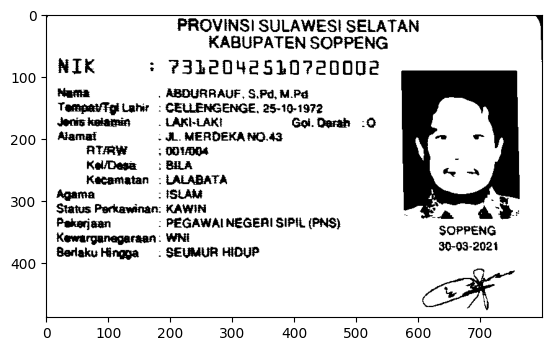

In [8]:
ktp_image_gray = cv2.cvtColor(ktp_denoised, cv2.COLOR_RGB2GRAY)
ktp_image_threshold = otsuThresholding(ktp_image_gray)
plt.imshow(ktp_image_threshold, cmap='gray')

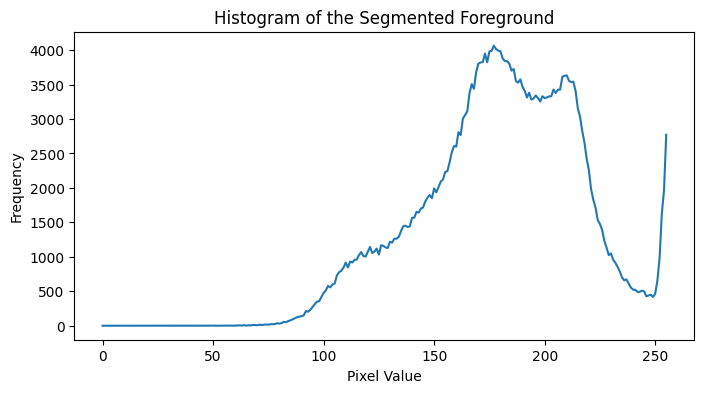

In [13]:
hist = cv2.calcHist([ktp_image], [0], ktp_image_threshold, [256], [0, 256])

plt.figure(figsize=(8, 4))
plt.plot(hist)
plt.title('Histogram of the Segmented Foreground')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


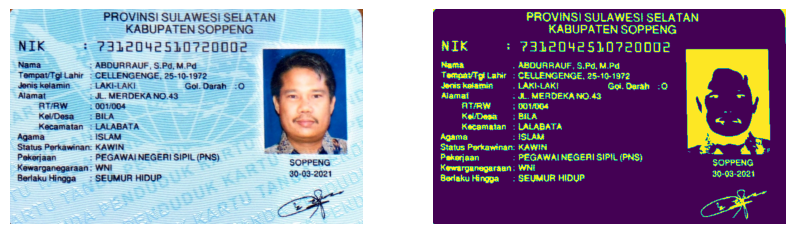

In [49]:
img_segmented = segment_image(ktp_denoised, 2)
compare_images(ktp_image, img_segmented)

In [52]:
text1 = pytesseract.image_to_data(ktp_image_threshold,output_type='data.frame')
text2 = pytesseract.image_to_string(ktp_image_threshold, lang="ind")

In [53]:
text = text1[text1.conf != -1]
lines = text.groupby('block_num')['text'].apply(list)
conf = text.groupby(['block_num'])['conf'].mean()

In [55]:
print(text2)

. ABDURRAUF, S.Pd, M.Pd

1: CELLENGENGE, 25-10-1972
LAKI-LAKI Goi. Darah :0
2 JL. MERDEKANG.43

1 0004

1 BRA

: LALABATA

2 ISLAM

: KAWIN
: PEGAWAI NEGERI SIPIL (PNS)
pn SEUMUR HIDUP

PROVINSI SULAWESI SELATAN
KABUPATEN SOPPENG

2310012510720002

   

TX 3.
SOPPENG
30-93-2021

Ka



(<Axes: >, <matplotlib.image.AxesImage at 0x7f7497d275b0>)

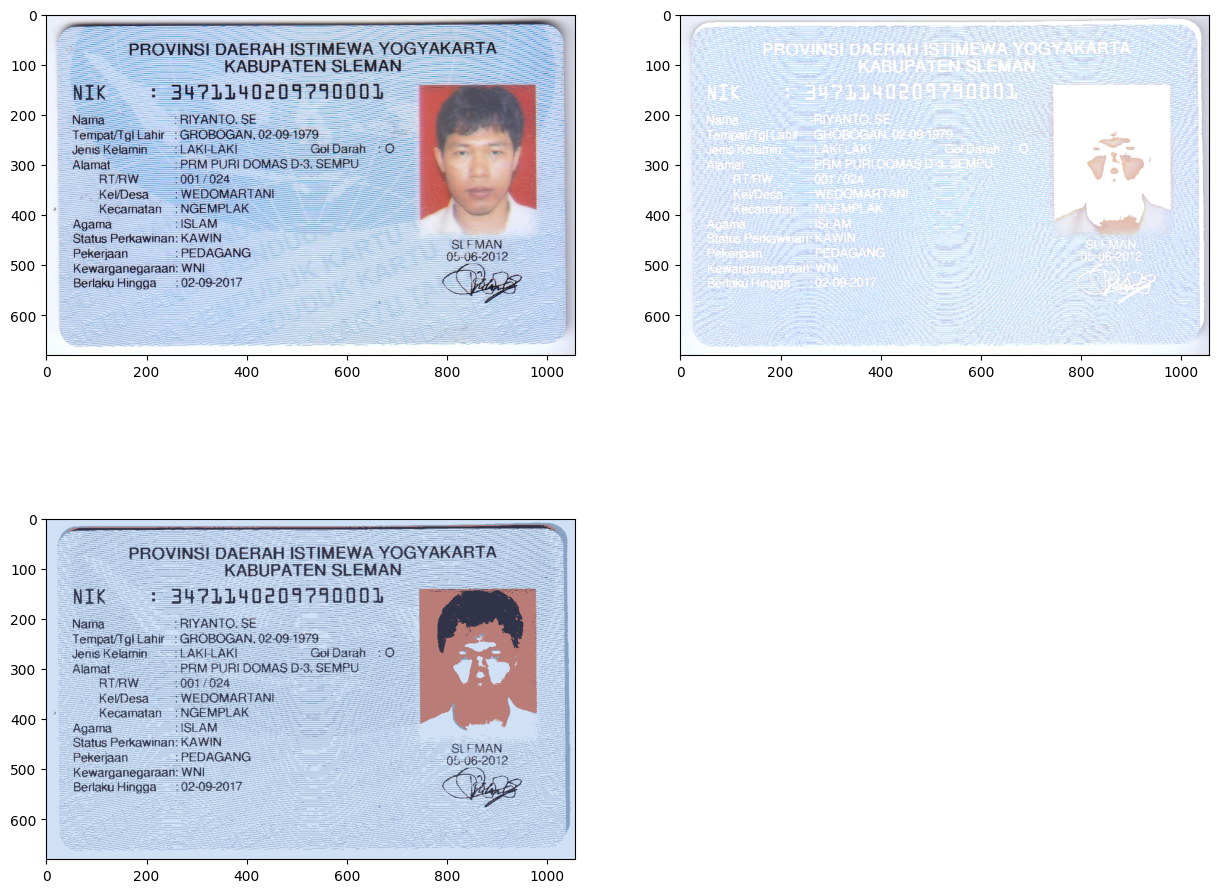

In [93]:
ktp_image = load_image('ktp.png')
pixel_values = ktp_image.reshape((-1, 3))
pixel_values = np.float32(pixel_values)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 150, 0.1)

k = 4  # Change the number of clusters to 4
_, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

centers = np.uint8(centers)

labels = labels.flatten()
segmented_image = centers[labels.flatten()]

segmented_image = segmented_image.reshape(ktp_image.shape)

masked_image = np.copy(ktp_image)
masked_image_data = masked_image.reshape((-1, 3))
masked_image_data[labels != 3] = [255, 255, 255]  # Change cluster label to 3
masked_image_data = masked_image_data.reshape(ktp_image.shape)

plt.figure(figsize=(15, 12))
plt.subplot(2, 2, 1), plt.imshow(ktp_image)
plt.subplot(2, 2, 2), plt.imshow(masked_image_data)
plt.subplot(2, 2, 3), plt.imshow(segmented_image)


## Another Method

In [69]:
se_3x3 = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))

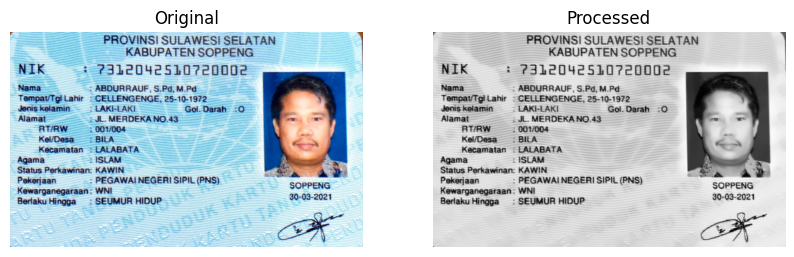

In [70]:
ktp_image_gray = cv2.cvtColor(ktp_denoised, cv2.COLOR_RGB2GRAY)
compare_images(ktp_image, ktp_image_gray, cmap='gray')

In [71]:
ret, threshed = cv2.threshold(ktp_image_gray, 127, 255, cv2.THRESH_TRUNC)

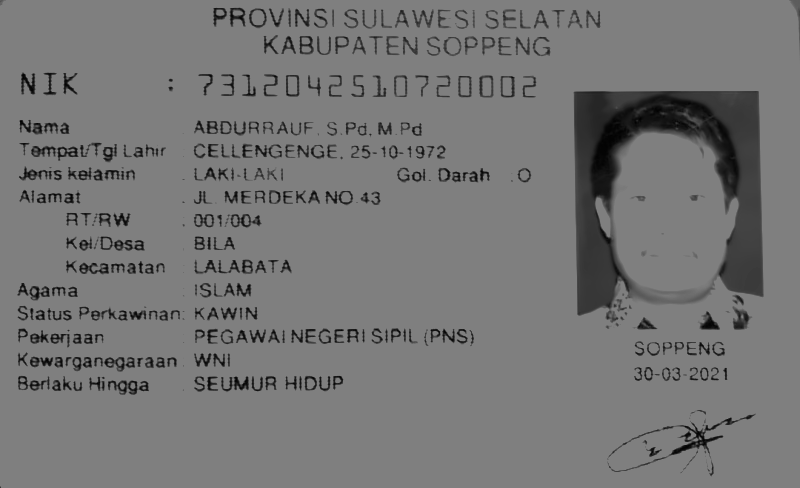

In [78]:
cv2_imshow(threshed)

In [79]:
ktp_image_gray = cv2.dilate(threshed, se_3x3)

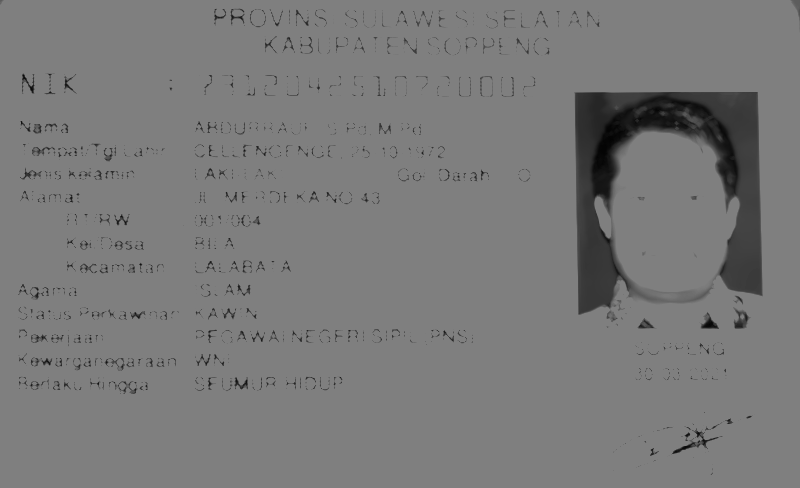

In [80]:
cv2_imshow(ktp_image_gray)

In [73]:
text1 = pytesseract.image_to_data(threshed,output_type='data.frame')
text2 = pytesseract.image_to_string(threshed, lang="ind")

In [74]:
text = text1[text1.conf != -1]
lines = text.groupby('block_num')['text'].apply(list)
conf = text.groupby(['block_num'])['conf'].mean()

In [75]:
from pytesseract import Output

img = cv2.imread('ktp.jpeg')

d = pytesseract.image_to_data(img, output_type=Output.DICT)
print(d.keys())

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])


In [76]:
print(text2)

PROVINSI SULAWESI SELATAN

KABUPATEN SOPPENG
NIK : ?312042510720002
Nama ABDURRAUF. S.Pd, MPd
Tempat/TgiLahir CELLENGENGE. 25-10-1972
Jenis kelamin LAKI-LAKI Gol. Darah .O
Alamat JL. MERDEKA NO.43
RTRW . 001/004

Kel/Desa BILA
Kecamatan  LALABATA

 

Agama ISLAM
Status Perkawinan: KAWIN -
Pekerjaan PEGAWAI NEGERI SIPIL (PNS) SOPPENG
Kewarganegaraan WNI

30-03-2021

Berlaku Hingga SEUMUR HIDUP



In [87]:
n_boxes = len(text1['text'])

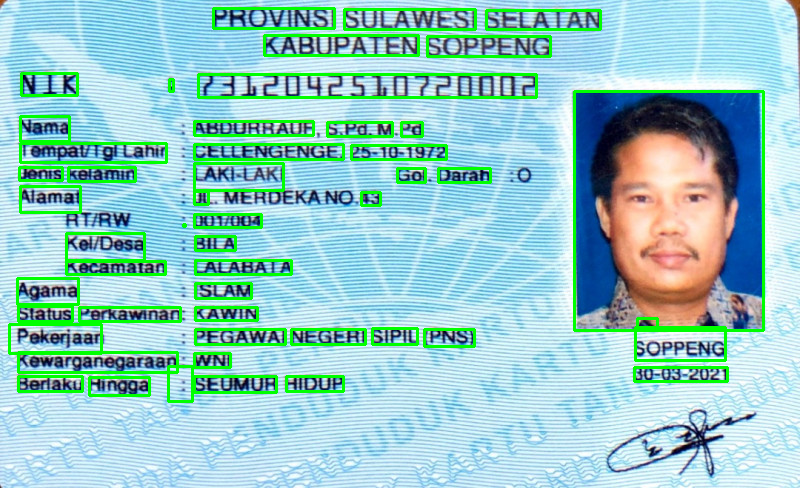

In [88]:
for i in range(n_boxes):
    if int(text1['conf'][i]) > 20:
        (x, y, w, h) = (text1['left'][i], text1['top'][i], text1['width'][i], text1['height'][i])
        img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

cv2_imshow(img)